In [1]:
# importing packages to be used in the notebook
import numpy as np
import matplotlib.pyplot as plt
import numba
import warnings
import os
warnings.simplefilter('always', RuntimeWarning)

# plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
# plt.rcParams.update({'font.size': 10})

plt.rcParams.update({'font.size': 15})
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 15}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#000000','#006BA2','#DB444B','#EBB434',
                                                    '#3EBCD2','#379A8B','#9A607F', '#B4BA39', '#754C24']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from sequence_jacobian import drawdag
from scipy.interpolate import interp1d
from types import SimpleNamespace

# importing own modules
import hh_labor # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Model 1: Endogenous labor supply

In [2]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, pi_e, Pi, a_grid


def transfers(pi_e, Div, Tax, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = e_grid, e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

def finacial_cost(a, rborr):
    a_neg = a.copy()
    a_neg[a>0] = 0
    fin_cost = np.abs(a_neg*(rborr * a_neg**2))
    return fin_cost

def wages(w, e_grid):
    we = w * e_grid
    return we

def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    # r = rstar(-1) + 0*phi * pi(-1)
    # r = rstar(-1) + phi * pi(-1) - pi
    return r


@simple
def fiscal(r, B):
    Tax = r * B
    return Tax


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa, FIN_COST):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y - FIN_COST
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

In [3]:
hh = hh_labor.hh
hh1 = hh.add_hetinputs([make_grid, transfers, wages])
hh_ext = hh1.add_hetoutputs([labor_supply, finacial_cost])

blocks_ss = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")
calibration = {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': -2.0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'B': 0.1, 'rborr': 0.009}

unknowns_ss = {'beta': 0.986, 'vphi': 0.8}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

# calibration['rborr'] = 0.15
ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

print(f"Asset market clearing: {ss0['goods_mkt']: 0.2e}")
calibration2 = calibration.copy()
calibration2['rborr'] = 0.0 #calibration['rborr']/10
ss1 = hank_ss.solve_steady_state(calibration2, unknowns_ss, targets_ss, solver="hybr")
print(f"Asset market clearing: {ss1['goods_mkt']: 0.2e}")

Asset market clearing:  4.65e-07
Asset market clearing: -1.71e-09


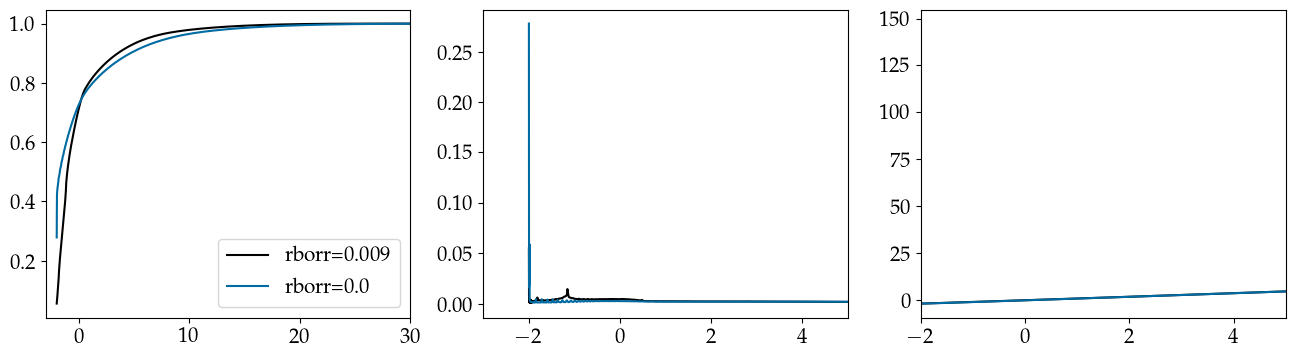

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax = ax.flatten()

amargdist = np.sum(ss0.internals['hh']['D'], axis=0)
amargdist1 = np.sum(ss1.internals['hh']['D'], axis=0)
ax[0].plot(ss0.internals['hh']['a_grid'],np.cumsum(amargdist), label=f"rborr={calibration['rborr']}")
ax[0].plot(ss1.internals['hh']['a_grid'],np.cumsum(amargdist1), label=f"rborr={calibration2['rborr']}")
ax[0].set_xlim(-3, 30)
# ax[0].set_ylim(0, 0.4)
ax[0].legend()

ax[1].plot(ss0.internals['hh']['a_grid'], amargdist)
ax[1].plot(ss1.internals['hh']['a_grid'], amargdist1)
ax[1].set_xlim(-3, 5)

ax[2].plot(ss0.internals['hh']['a_grid'], ss0.internals['hh']['a'][1].T)
ax[2].plot(ss1.internals['hh']['a_grid'], ss1.internals['hh']['a'][1].T)
ax[2].set_xlim(-2, 5)

plt.show()

In [6]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

ss = hank.steady_state(ss0)
ss_no = hank.steady_state(ss1)

rho_r, sig_r = 0.5, 0.01/4
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock_path, verbose = False)
td1_nonlin = hank.solve_impulse_linear(ss_no, unknowns, targets, rstar_shock_path, verbose = False)

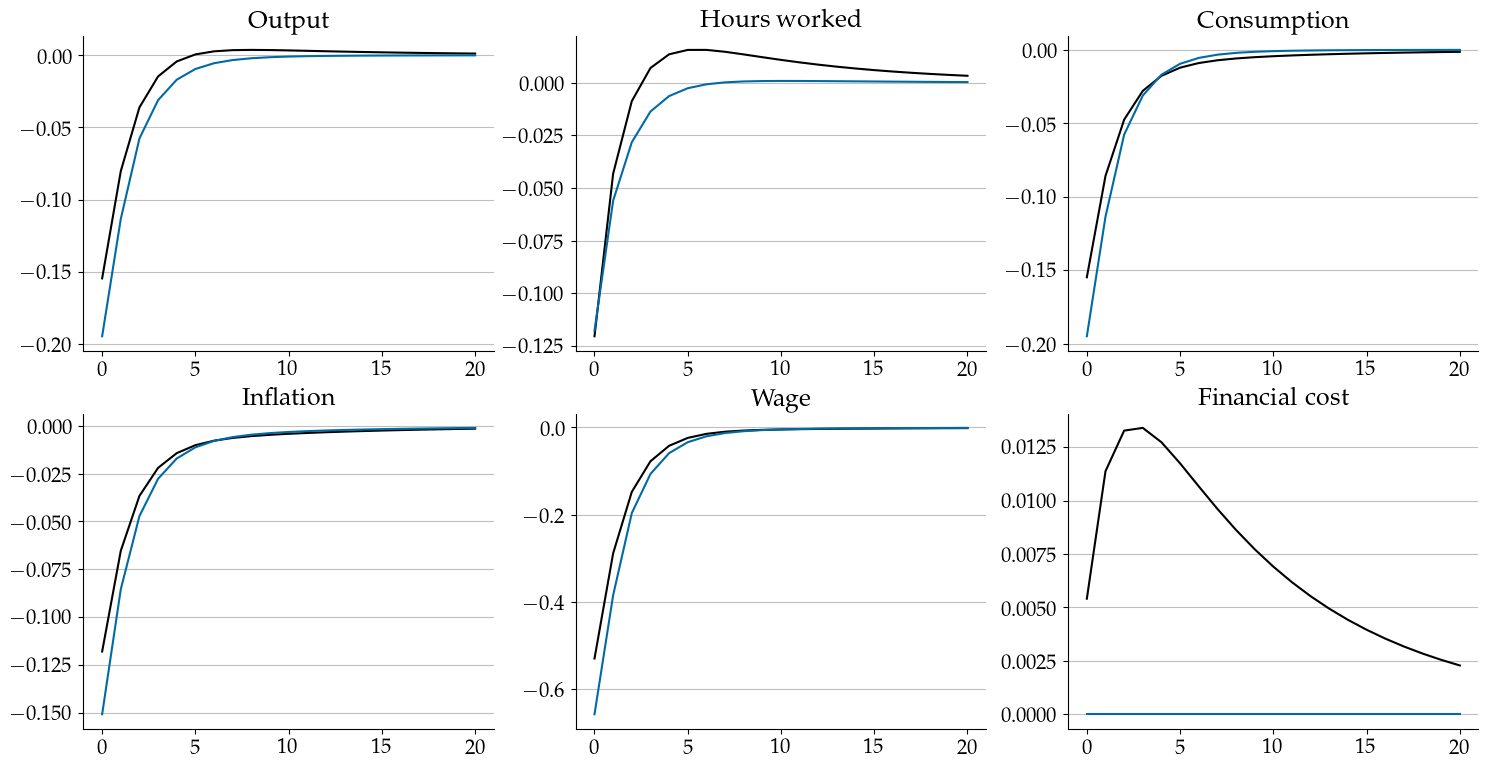

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(18,9))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C': 'Consumption', 
            'pi': 'Inflation', 'w': 'Wage', 'FIN_COST': 'Financial cost'}
var_plot = ['Y', 'N', 'C', 'pi', 'w', 'FIN_COST']

for i, var in enumerate(var_plot):
    ax[i].plot(100*td_nonlin[var][:21])
    ax[i].plot(100*td1_nonlin[var][:21])
    ax[i].set_title(var_name[var])

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(True, axis='y', color='black', alpha=0.25, linestyle='-')

# Model 2. Model with capital

In [241]:
import hh_twoasset
import sequence_jacobian.examples.two_asset as m

In [242]:
@solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc'], solver="brentq")
def pricing_solved(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / \
           (1 + r(+1)) - (1 + pi).apply(np.log)
    return nkpc

@solved(unknowns={'p': (5, 15)}, targets=['equity'], solver="brentq")
def arbitrage_solved(div, p, r):
    equity = div(+1) + p(+1) - p * (1 + r(+1))
    return equity

@simple
def labor(Y, w, K, Z, alpha):
    N = (Y / Z / K(-1) ** alpha) ** (1 / (1 - alpha))
    mc = w * N / (1 - alpha) / Y
    return N, mc

@simple
def investment(Q, K, r, N, mc, Z, delta, epsI, alpha):
    inv = (K / K(-1) - 1) / (delta * epsI) + 1 - Q
    val = alpha * Z(+1) * (N(+1) / K) ** (1 - alpha) * mc(+1) -\
        (K(+1) / K - (1 - delta) + (K(+1) / K - 1) ** 2 / (2 * delta * epsI)) +\
        K(+1) / K * Q(+1) - (1 + r(+1)) * Q
    return inv, val

production = combine([labor, investment])                              # create combined block
production_solved = production.solved(unknowns={'Q': 1., 'K': 10.},    # turn it into solved block
                                      targets=['inv', 'val'],
                                      solver='broyden_custom')

def make_grids(bmax, amax, amin, kmax, nB, nA, nK, nZ, rho_z, sigma_z):
    b_grid = grids.agrid(amax=bmax, n=nB, amin = amin)
    a_grid = grids.agrid(amax=amax, n=nA)
    k_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    return b_grid, a_grid, k_grid, e_grid, Pi

def income(e_grid, tax, w, N):
    z_grid = (1 - tax) * w * N * e_grid
    return z_grid

# def finacial_cost(b, rborr):
#     b_neg = b.copy()
#     b_neg[b>0] = 0
#     fin_cost = np.abs(b_neg*rborr)
#     return fin_cost

def finacial_cost(b, rborr):
    b_neg = b.copy()
    b_neg[b>0] = 0
    # fin_cost = np.abs(b_neg*rborr)
    fin_cost = np.abs(b_neg*(rborr * b_neg**2))
    return fin_cost

@simple
def mkt_clearing(p, A, B, Bg, C, I, G, CHI, psip, omega, Y, FIN_COST):
    wealth = A + B
    asset_mkt = p + Bg - wealth
    goods_mkt = C + I + G + CHI + psip + omega * B + FIN_COST - Y
    return asset_mkt, wealth, goods_mkt

hh = hh_twoasset.hh
hh_ext = hh.add_hetinputs([income, make_grids])

In [243]:
blocks = [hh_ext, production_solved, pricing_solved, arbitrage_solved,
          m.dividend, m.taylor, m.fiscal, m.share_value,
          m.finance, m.wage, m.union, mkt_clearing]

hank = create_model(blocks, name='Two-Asset HANK')

print(*hank.blocks, sep='\n')

<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SimpleBlock 'wage'>
<SimpleBlock 'taylor'>
<SimpleBlock 'dividend'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'share_value'>
<SimpleBlock 'finance'>
<SimpleBlock 'fiscal'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `finacial_cost_adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>


In [244]:
blocks_ss = [hh_ext, m.partial_ss, m.union_ss,
             m.dividend, m.taylor, m.fiscal, m.share_value, m.finance, mkt_clearing]

hank_ss = create_model(blocks_ss, name='Two-Asset HANK SS')

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

<Model 'Two-Asset HANK SS'>
Inputs: ['beta', 'eis', 'chi0', 'chi1', 'chi2', 'rborr', 'N', 'bmax', 'amax', 'amin', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'K', 'r', 'tot_wealth', 'Bg', 'delta', 'muw', 'frisch', 'pi', 'kappap', 'epsI', 'rstar', 'phi', 'G', 'Bh', 'omega']


In [ ]:
calibration = {'Y': 1., 'N': 1.0, 'K': 10., 'r': 0.0125, 'rstar': 0.0125, 'tot_wealth': 14,
               'delta': 0.02, 'pi': 0., 'kappap': 0.1, 'muw': 1.1, 'Bh': 1.04, 'Bg': 2.8,
               'G': 0.2, 'eis': 0.5, 'frisch': 1., 'chi0': 0.25, 'chi2': 2, 'epsI': 4,
               'omega': 0.005, 'kappaw': 0.1, 'phi': 1.5, 'nZ': 3, 'nB': 50, 'nA': 70, 'nK': 50,
               'bmax': 50, 'amax': 4000, 'kmax': 1, 'rho_z': 0.966, 'sigma_z': 0.92, 'rborr': 0.03, 'amin': -1.0}

unknowns_ss = {'beta': 0.976, 'chi1': 6.5}
targets_ss = {'asset_mkt': 0., 'B': 'Bh'}

cali = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='broyden_custom')
print('Done ')
calibration2 = calibration.copy()
calibration2['rborr'] = 0.06
unknowns_ss = {'beta': 0.976, 'chi1': 9.0}
cali2 = hank_ss.solve_steady_state(calibration2, unknowns_ss, targets_ss, solver='broyden_custom')

ss =  hank.steady_state(cali)
ss2 = hank.steady_state(cali2)

print(f"Liquid assets: {ss['B']: 0.2f}")
print(f"Asset market clearing: {ss['asset_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss['goods_mkt']: 0.2e}")

Done 


ValueError: No convergence of policy functions after 5000 backward iterations!

In [247]:
print(f"Liquid assets: {ss2['chi1']: 0.2f}")

Liquid assets:  5.58


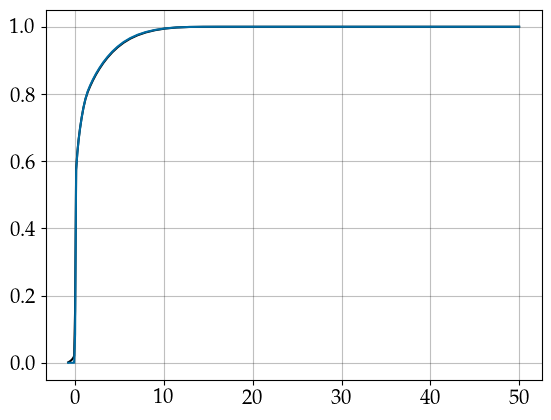

In [248]:
bamargdist = np.sum(ss.internals['hh']['D'], axis=0)
bamargdist1 = np.sum(ss2.internals['hh']['D'], axis=0)

b_margdist = np.sum(bamargdist,axis=1) # sum out illiquid assets
b1_margdist = np.sum(bamargdist1,axis=1) # sum out illiquid assets

plt.plot(ss.internals['hh']['b_grid'],np.cumsum(b_margdist))
plt.plot(ss.internals['hh']['b_grid'],np.cumsum(b1_margdist))

In [249]:
exogenous = ['rstar', 'Z', 'G']
unknowns = ['r', 'w', 'Y']
targets = ['asset_mkt', 'fisher', 'wnkpc']
T = 300
rho_r, sig_r = 0.61, 0.01/4
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}

td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock_path)
td1_nonlin = hank.solve_impulse_nonlinear(ss2, unknowns, targets, rstar_shock_path)

Solving Two-Asset HANK for ['r', 'w', 'Y'] to hit ['asset_mkt', 'fisher', 'wnkpc']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv', 'val']
On iteration 0
   max error for inv is 0.00E+00
   max error for val is 0.00E+00
Solving pricing_solved_inner for ['pi'] to hit ['nkpc']
On iteration 0
   max error for nkpc is 0.00E+00
Solving arbitrage_solved_inner for ['p'] to hit ['equity']
On iteration 0
   max error for equity is 0.00E+00
On iteration 0
   max error for asset_mkt is 6.66E-06
   max error for fisher is 2.50E-03
   max error for wnkpc is 9.99E-08
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv', 'val']
On iteration 0
   max error for inv is 0.00E+00
   max error for val is 2.07E-03
On iteration 1
   max error for inv is 9.95E-07
   max error for val is 9.11E-06
On iteration 2
   max error for inv is 4.51E-09
   max error for val is 2.50E-08
On iteration 3
   max error for inv is 8.99E-12
   max error for val is 3.28E-10
Solving pricing_solved_i

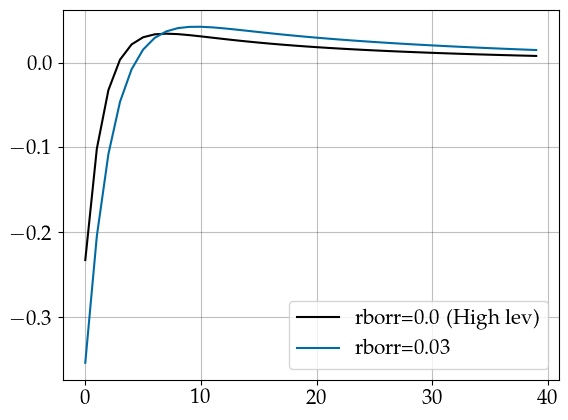

In [203]:
plt.plot(100*td_nonlin['I'][:40], label=f"rborr={calibration['rborr']} (High lev)")
plt.plot(100*td1_nonlin['I'][:40], label = f"rborr={calibration2['rborr']}")
plt.legend()

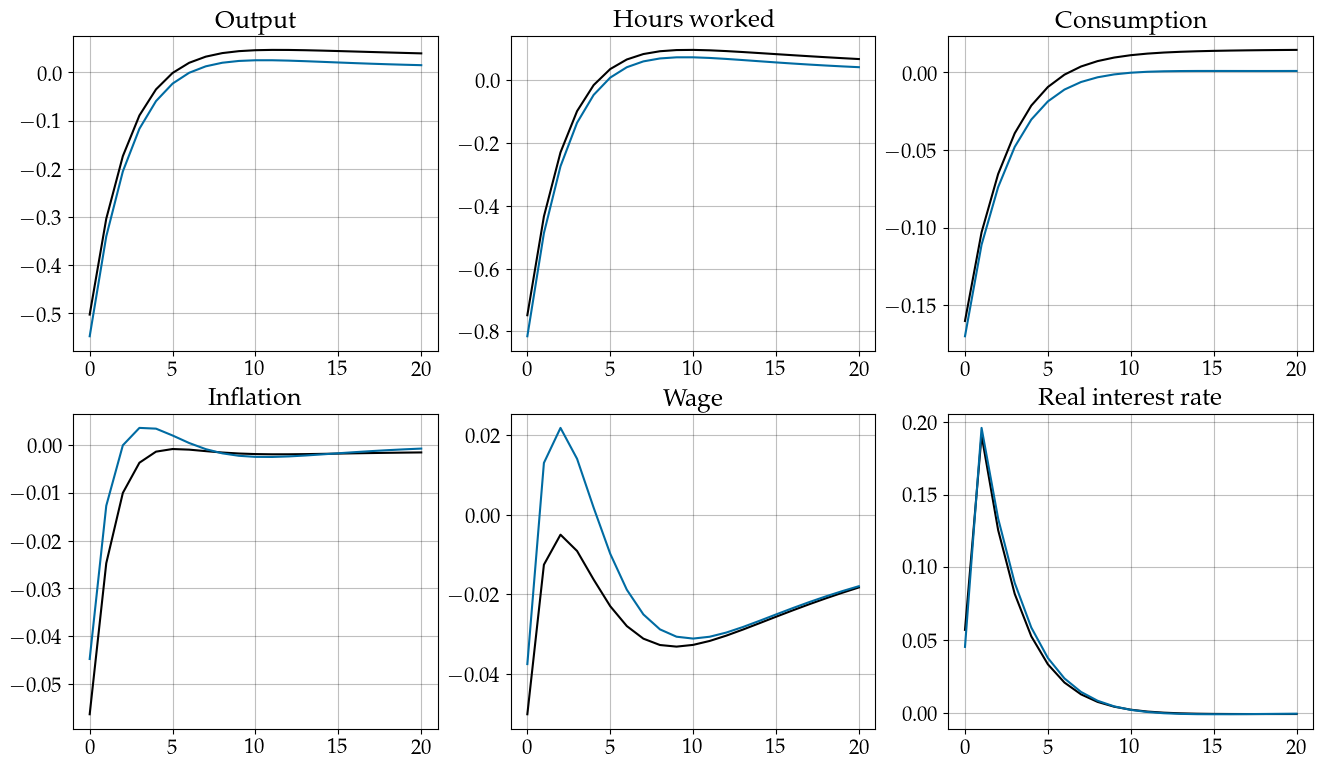

In [250]:
fig, ax = plt.subplots(2, 3, figsize=(16,9))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C': 'Consumption', 
            'pi': 'Inflation', 'w': 'Wage', 'r': 'Real interest rate'}
var_plot = ['Y', 'N', 'C', 'pi', 'w', 'r']

for i, var in enumerate(var_plot):
    ax[i].plot(100*td_nonlin[var][:21])
    ax[i].plot(100*td1_nonlin[var][:21])
    ax[i].set_title(var_name[var])